In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sklearn

In [2]:
interest = pickle.load(open("interest_ready.pickle"))

In [3]:
# print summary statistics of raw features
df = pd.concat([interest.dtypes, interest.mean(axis=0), interest.std(axis=0)], axis=1)
df.columns = ["dtype", "mean", "std"]
df

,dtype,mean,std
X1,float64,0.139463,0.043779
X4,float64,14276.968353,8252.264104
X5,float64,14248.306140,8238.064335
X6,float64,14182.000445,8255.138412
X8,float64,2.808658,1.314939
X9,float64,12.052704,6.496930
X11,float64,5.991935,3.534170
X13,float64,73147.445129,51749.421285
X15,float64,13.027980,1.167932
X21,float64,16.997242,7.697223


A subset of features have been manually removed in the previous exploratory analysis

In [4]:
y = interest.values[:, 0]   # target: first column
X = interest.values[:, 1:]  # features: column with index >= 1
del interest

In [5]:
# Hold-out test set (20%) for final evaluation

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Random Forest

Random Forest - Best params:
{'estimator__max_samples': 1.0, 'dim_reduction': None, 'estimator__base_estimator__max_depth': 10, 'estimator__base_estimator__min_samples_split': 10}

Random Forest - Best model:
GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('estimator', BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'...estimators=50, n_jobs=6, oob_score=False,
         random_state=None, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'estimator__max_samples': [0.1, 1.0], 'dim_reduction': [PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), None], 'estimator__base_estimator__max_depth': [10, 20], 'estimator__base_esti

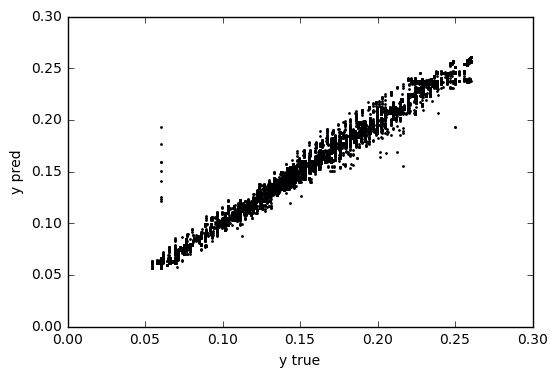

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

rf = BaggingRegressor(DecisionTreeRegressor(max_depth=20, min_samples_split=20,
                                               min_samples_leaf=1), max_samples=0.1, n_estimators=50, n_jobs=6)

pl = Pipeline(steps=[("scaler", StandardScaler()),
                     ("dim_reduction", PCA(n_components=0.95)),
                     ("estimator", rf)])

model = GridSearchCV(pl, dict(dim_reduction=[PCA(n_components=0.95), None],
                              estimator__base_estimator__max_depth=[10, 20],
                              estimator__base_estimator__min_samples_split=[10],
                              estimator__max_samples=[0.1, 1.0]))
model.fit(X_train, y_train)
print "Random Forest - Best params:"
print model.best_params_
print
print "Random Forest - Best model:"
print model
print 
print "Random Forest - Score on test set:"
# R-squared
print model.score(X_test, y_test)

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, s=1)
plt.xlabel("y true")
plt.ylabel("y pred")
plt.show()

# Bagging SGDRegressor

Bagging SGDRegressor - Best params:
{'dim_reduction': None, 'estimator__base_estimator__alpha': 0.0001}

Bagging SGDRegressor - Best model:
GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('estimator', BaggingRegressor(base_estimator=SGDRegressor(alpha=0.0001, average=Fa...estimators=50, n_jobs=6, oob_score=False,
         random_state=None, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'dim_reduction': [PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), None], 'estimator__base_estimator__alpha': [0.01, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Bagging SGDRegressor - 

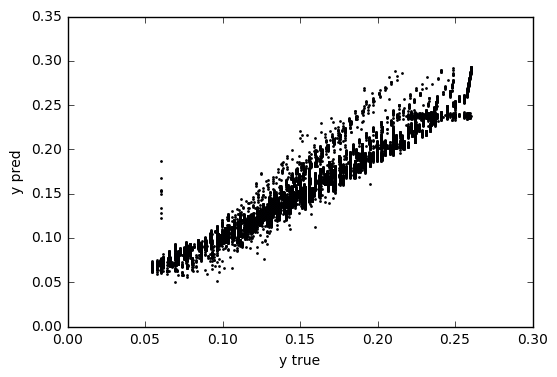

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

bg_sgdr = BaggingRegressor(SGDRegressor(), n_estimators=50,
                           max_samples=1.0, n_jobs=6)
pl = Pipeline(steps=[("scaler", StandardScaler()),
                     ("dim_reduction", PCA(n_components=0.95)),
                     ("estimator", bg_sgdr)])

model = GridSearchCV(pl, dict(dim_reduction=[PCA(n_components=0.95), None],
                              estimator__base_estimator__alpha=[0.01, 0.0001]))
model.fit(X_train, y_train)
print "Bagging SGDRegressor - Best params:"
print model.best_params_
print
print "Bagging SGDRegressor - Best model:"
print model
print 
print "Bagging SGDRegressor - Score on test set:"
# R-squared
print model.score(X_test, y_test)

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, s=1)
plt.xlabel("y true")
plt.ylabel("y pred")
plt.show()

# Bagging Neural Network

Bagging MLPRegressor - Best params:
{'dim_reduction': None, 'estimator__base_estimator__alpha': 0.01}

Bagging MLPRegressor - Best model:
GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('estimator', BaggingRegressor(base_estimator=MLPRegressor(activation='relu', alpha...estimators=20, n_jobs=6, oob_score=False,
         random_state=None, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'dim_reduction': [PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), None], 'estimator__base_estimator__alpha': [0.01, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Bagging MLPRegressor - Sc

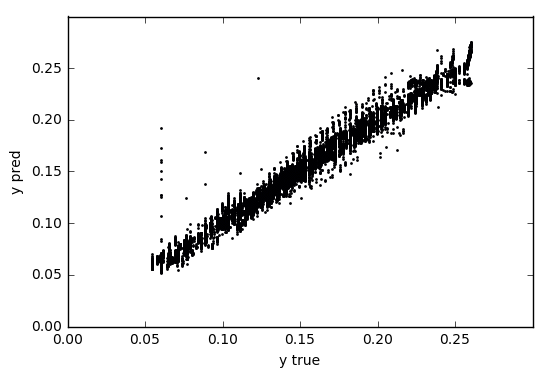

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

bg_ann = BaggingRegressor(MLPRegressor(), n_estimators=20,
                       n_jobs=6, max_samples=1.0)
pl = Pipeline(steps=[("scaler", StandardScaler()),
                     ("dim_reduction", PCA()),
                     ("estimator", bg_ann)])

model = GridSearchCV(pl, dict(dim_reduction=[PCA(n_components=0.95), None],
                              estimator__base_estimator__alpha=[0.01, 0.0001]))
model.fit(X_train, y_train)
print "Bagging MLPRegressor - Best params:"
print model.best_params_
print
print "Bagging MLPRegressor - Best model:"
print model
print 
print "Bagging MLPRegressor - Score on test set:"
# R-squared
print model.score(X_test, y_test)

y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, s=1)
plt.xlabel("y true")
plt.ylabel("y pred")
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.show()